In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from datetime import timedelta
from itertools import count
import os
import sys
import pickle
from timeit import default_timer as timer
from datetime import timedelta
from IPython.display import clear_output

import gym

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, optimizers

import tensorflow_probability as tfp

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# tf.config.list_physical_devices(device_type='GPU')

In [2]:
seed = 1
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。

tf.random.set_seed(seed)
# tensorflow 如何设置在GPU上能够复现结果还不太清楚怎么弄

In [3]:
# hyperparameter
training_env_seed = 123
lr = 1e-4
gamma = 0.99

# Policy

In [4]:
class Policy(keras.Model):
    def __init__(self, action_dim):
        super(Policy, self).__init__()
        
        self.action_dim = action_dim
        
        self.affine1 = layers.Dense(128)
        self.dropout = layers.Dropout(rate=0.6)
        self.affine2 = layers.Dense(self.action_dim)
        
    def call(self, obs, training=None):
        x = tf.convert_to_tensor(obs, dtype=tf.float32)
        x = self.affine1(x)
        x = self.dropout(x)
        x = tf.nn.relu(x)
        x = tf.nn.softmax(self.affine2(x))
        return x

# Agent

In [5]:
class Agent(object):
    def __init__(self, env_name, policy=Policy):
        
        self.env = gym.make(env_name)
        
        self.action_dim = self.env.action_space.n
        
        self.policy = policy(self.action_dim)
        
        self.optimizer = optimizers.Adam(learning_rate=lr)
        self.gamma = gamma
        
    
    def get_action(self, obs, training=None):
        prob = self.policy(np.expand_dims(obs, 0), training=training)
        m = tfp.distributions.Categorical(probs=prob)
        action = m.sample()
        return int(action.numpy()[0])
    
    
    def train(self, obses, rewards, actions):
        R = 0
        discounted_returns = []
        for r in rewards[::-1]:
            R = self.gamma * R + r
            discounted_returns.insert(0, R)
        
        for obs, reward_to_go, action in zip(obses, discounted_returns, actions):
            with tf.GradientTape() as tape:
                p = self.policy(np.expand_dims(obs, 0))
                loss = self.compute_loss(p, reward_to_go, action)
            grads = tape.gradient(loss, self.policy.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.policy.trainable_variables))
            
                                           
    def compute_loss(self, prob, reward_to_go, action):
        m = tfp.distributions.Categorical(prob)
        log_prob = m.log_prob(action)
        loss = reward_to_go * -log_prob
        return loss
    
    
    def eval_(self, env, n_trajs=5):
        returns = []
        for i in range(n_trajs):
            ep_return = 0
            obs = env.reset()
            for step in range(10000):
                action = self.get_action(obs, training=False)
                obs, reward, done, _ =env.step(action)
                ep_return += reward
                
                if done:
                    returns.append(ep_return)
                    break 
        return np.array(returns).mean()
    
    
    def render(self, env):
        obs = env.reset()
        for _ in range(10000):
            env.render()
            action = self.get_action(obs, training=False)
            obs, reward, done, _ = env.step(action)
            if done:
                break
        
        
    def save(self, step):
        self.policy.save_weights('./reinforce_{}.ckpt'.format(step))
        
    def load(self, path):
        if os.path.isfile(path):
            self.policy.load_weights(path)            
        else:
            print('No "{}" exits for loading'.format(path))

## tensorflow和pytorch在写法上会有不同，如果按照pytorch相同的写法，会导致在计算梯度：tape.gradient(loss, self.policy.trainable_variables)时获取不到相应的梯度

# Trainging Loop

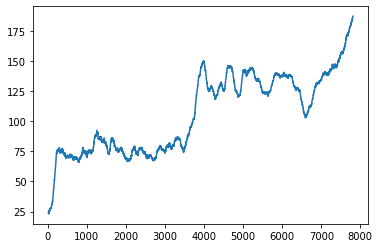

total reward after 7811 episodes is 200.0
total reward after 7812 episodes is 198.0
total reward after 7813 episodes is 200.0
Solved, the eval return is 195.03


In [6]:
env_name = 'CartPole-v0'
env_eval = gym.make(env_name)
agent_reinforce = Agent(env_name, Policy)

start = timer()
running_returns = []

for episode in count(1):
    total_reward = 0
    obs = agent_reinforce.env.reset()
    obses = []
    actions = []
    rewards = []
    done = False
    
    while not done:
        action = agent_reinforce.get_action(obs)
        obses.append(obs)
        actions.append(action)
        obs, reward, done, _ = agent_reinforce.env.step(action)
        rewards.append(reward)
        total_reward += reward
        
        if done:
            agent_reinforce.train(obses, rewards, actions)
            running_returns.append(total_reward)
            print('total reward after {} episodes is {}'.format(episode, total_reward))
            
    
    if episode % 10 == 0:
        clear_output(True)
        plt.plot(pd.Series(running_returns).rolling(100, 20).mean())
        plt.title('episide:{}, time:{}, returns'.format(episode, timedelta(seconds=int(timer()-start))))
        plt.show()
        
    
    if np.array(running_returns)[-20:].mean() > 195:
        eval_return = agent_reinforce.eval_(env_eval, 100)
        if eval_return > 195:
            print('Solved, the eval return is {}'.format(eval_return))
            break

In [7]:
agent_reinforce.policy.save_weights('./reinforce_cartpole.ckpt')